In [49]:
# Import library yang ingin digunakan

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import transforms
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

In [50]:
print(torch.__version__)

2.3.0+cpu


In [51]:
# Path data yg dipakai
training_dataset_path = './train_images/'
testing_dataset_path = './test_images/'

# Fungsi untuk cek folder, memastikan class yang digunakan sesuai
def cek_folder(path):
    # List direktori
    files = os.listdir(path)

    # Cek foldernya saja
    filtered_files = [file for file in files if not file.endswith(('.png', '.jpg'))]

    print("Folder direktori class.. ", filtered_files)
cek_folder(training_dataset_path)
cek_folder(testing_dataset_path)

Folder direktori class..  ['melanoma', 'not_melanoma']
Folder direktori class..  []


In [52]:
# Fungsi untuk load data dan melakukan normalize
def load_and_normalize(path, batch_size=32, sampler=None):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = ImageFolder(root=path, transform=transform)
    print("Berhasil memuat dataset..")
    print("Indeks kelas: " + str(dataset.class_to_idx))

    if sampler is not None:
        print("sampler")
        loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    else:
        print("no sampler")
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    print("Berhasil membuat data loader..")
    return loader

# Me-split dataset menjadi data training dan validation
dataset = ImageFolder(root=training_dataset_path, transform=transforms.ToTensor())
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

train_split = int(0.8 * dataset_size)
train_indices = indices[:train_split]
val_indices = indices[train_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Load training and validation data
train_loader = load_and_normalize(training_dataset_path, sampler=None)
val_loader = load_and_normalize(training_dataset_path, sampler=None)

Berhasil memuat dataset..
Indeks kelas: {'melanoma': 0, 'not_melanoma': 1}
no sampler
Berhasil membuat data loader..
Berhasil memuat dataset..
Indeks kelas: {'melanoma': 0, 'not_melanoma': 1}
no sampler
Berhasil membuat data loader..


In [53]:
# Menggunakan custom dataset untuk data testing
# Perbedaan dengan data training: data testing tidak memiliki label kelas sendiri

class CustomTestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.image_files = [file for file in os.listdir(path) if file.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.path, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')  # Ensure 3 channels (RGB)
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]

In [54]:
# Mendefinisikan transformasi yang dilakukan pada data testing
# Perhatikan bahwa data testing juga dilakukan preprocessing tapi tanpa augmentasi yang dapat mengubah gambar secara signifikan, karena tujuannya adalah evaluasi model.

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_dataset = CustomTestDataset(path='./test_images/', transform=transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(test_loader)

In [55]:
# Mengecek ukuran gambar

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


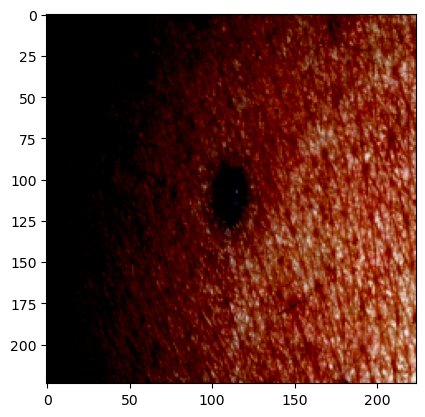

In [56]:
# Melihat sekilas dataset

# Konversi tensor ke numpy array, lalu transpose dimensinya
image = images[1].numpy().transpose((1, 2, 0))

plt.imshow(image)
plt.show()

In [57]:
# Mendefinisikan arsitektur convolutional neural network sederhana
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.5) 
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(4 * 56 * 56, 10),
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


In [58]:
# Model yang digunakan
model = Net()

# Optimizer: pakai Adam
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Loss function: pakai Cross Entropy
criterion = nn.CrossEntropyLoss()

# Scheduler untuk menurunkan learning rate jika tidak ada perbaikan pada validation loss
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose=True)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.5, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=12544, out_features=10, bias=True)
  )
)


C:\Users\afiqi\anaconda\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [59]:
# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [60]:
# Menentukan device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

CrossEntropyLoss()

Epoch 1 - Training loss: 1.2230 - Validation loss: 1.5937 - Training Accuracy: 0.4743 - Validation Accuracy: 0.5829 - Training F1-score: 0.1105 - Validation F1-score: 0.5815
Epoch 2 - Training loss: 0.7146 - Validation loss: 1.0174 - Training Accuracy: 0.5714 - Validation Accuracy: 0.6229 - Training F1-score: 0.5687 - Validation F1-score: 0.5848
Epoch 3 - Training loss: 0.7059 - Validation loss: 0.7769 - Training Accuracy: 0.6171 - Validation Accuracy: 0.6171 - Training F1-score: 0.5661 - Validation F1-score: 0.4952
Epoch 4 - Training loss: 0.6407 - Validation loss: 0.6768 - Training Accuracy: 0.6857 - Validation Accuracy: 0.6571 - Training F1-score: 0.6624 - Validation F1-score: 0.5748
Epoch 5 - Training loss: 0.6671 - Validation loss: 0.6269 - Training Accuracy: 0.6000 - Validation Accuracy: 0.6629 - Training F1-score: 0.5791 - Validation F1-score: 0.6108
Epoch 6 - Training loss: 0.6511 - Validation loss: 0.5983 - Training Accuracy: 0.6686 - Validation Accuracy: 0.6914 - Training F1-

Epoch 48 - Training loss: 0.3191 - Validation loss: 0.2526 - Training Accuracy: 0.8857 - Validation Accuracy: 0.9257 - Training F1-score: 0.8810 - Validation F1-score: 0.9238
Epoch 49 - Training loss: 0.3077 - Validation loss: 0.2501 - Training Accuracy: 0.8743 - Validation Accuracy: 0.9314 - Training F1-score: 0.8712 - Validation F1-score: 0.9298
Epoch 50 - Training loss: 0.2701 - Validation loss: 0.2356 - Training Accuracy: 0.9543 - Validation Accuracy: 0.9429 - Training F1-score: 0.9528 - Validation F1-score: 0.9415


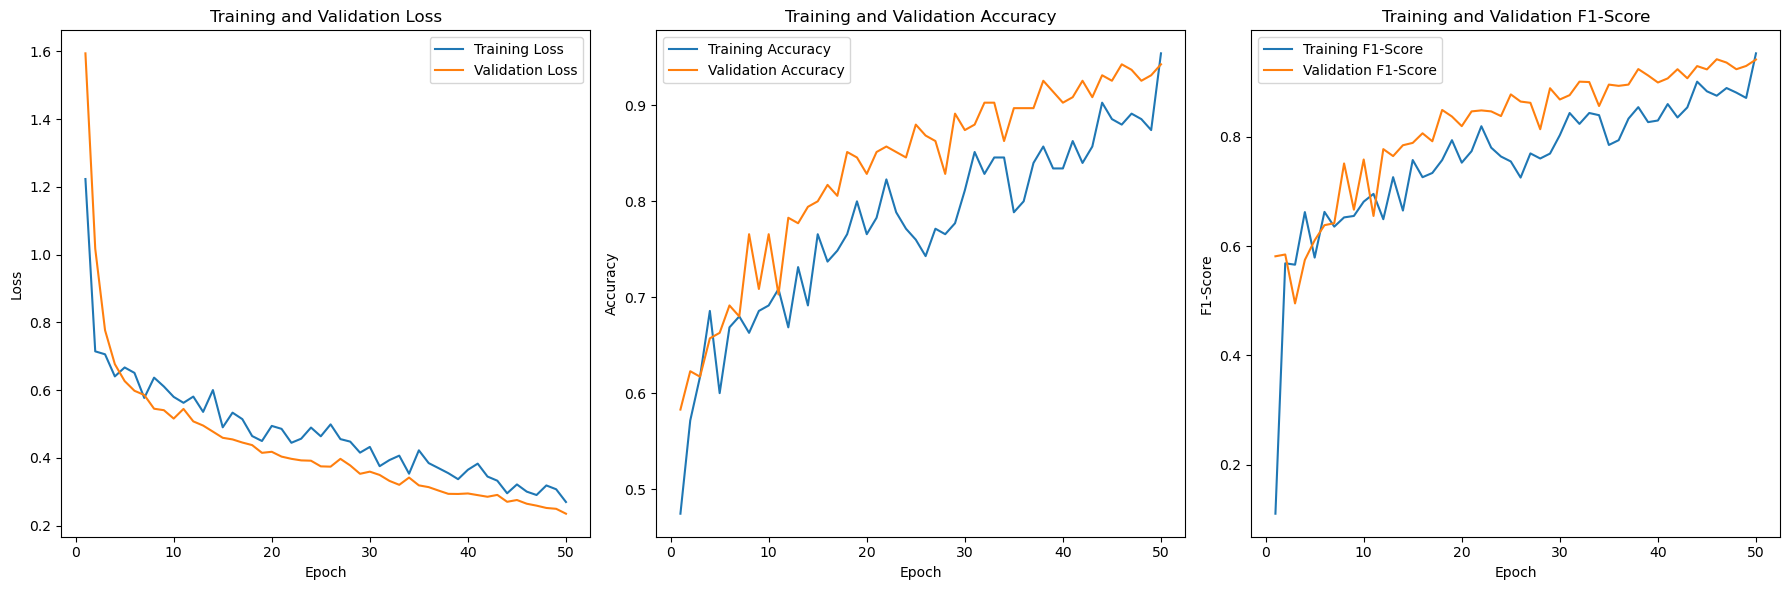

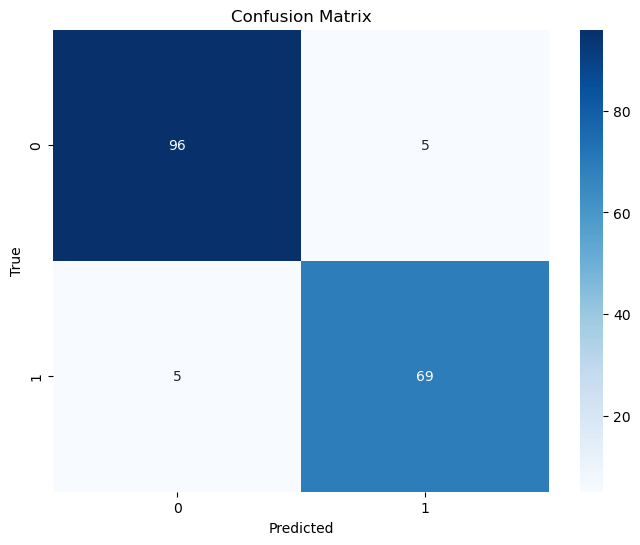

In [61]:
# Menyimpan nilai loss, akurasi, dan f1-score untuk setiap epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

# Training loop
num_epochs = 50
early_stopping = EarlyStopping(patience=7, min_delta=0.001)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_count_train, all_count_train = 0, 0
    all_labels_train = []
    all_predictions_train = []

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
        _, predicted_train = torch.max(outputs, 1)
        all_count_train += target.size(0)
        correct_count_train += (predicted_train == target).sum().item()
        
        all_labels_train.extend(target.cpu().numpy())
        all_predictions_train.extend(predicted_train.cpu().numpy())

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_count_train / all_count_train
    train_f1 = f1_score(all_labels_train, all_predictions_train, average='macro')

    model.eval()
    val_loss = 0.0
    correct_count_val, all_count_val = 0, 0
    all_labels_val = []
    all_predictions_val = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item() * data.size(0)
            
            _, predicted_val = torch.max(outputs, 1)
            all_count_val += target.size(0)
            correct_count_val += (predicted_val == target).sum().item()
            
            all_labels_val.extend(target.cpu().numpy())
            all_predictions_val.extend(predicted_val.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_count_val / all_count_val
    val_f1 = f1_score(all_labels_val, all_predictions_val, average='macro')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f'Epoch {epoch + 1} - Training loss: {train_loss:.4f} - Validation loss: {val_loss:.4f} - '
          f'Training Accuracy: {train_accuracy:.4f} - Validation Accuracy: {val_accuracy:.4f} - '
          f'Training F1-score: {train_f1:.4f} - Validation F1-score: {val_f1:.4f}')

    scheduler.step(val_loss)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Membuat plot loss, akurasi, dan f1-score
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(18, 6))

# Plot Training dan Validation Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training dan Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Training dan Validation F1-Score
plt.subplot(1, 3, 3)
plt.plot(epochs, train_f1_scores, label='Training F1-Score')
plt.plot(epochs, val_f1_scores, label='Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Training and Validation F1-Score')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels_val, all_predictions_val)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels_val), yticklabels=np.unique(all_labels_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [62]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluasi model
correct_count, all_count = 0, 0
all_labels = []
all_predictions = []

model.eval()

for images, labels in train_loader:  # gunakan val_loader untuk evaluasi validasi
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
        
    with torch.no_grad():
        outputs = model(images)
        
    _, predicted = torch.max(outputs, 1)
    all_count += labels.size(0)
    correct_count += (predicted == labels).sum().item()
    
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

accuracy = correct_count / all_count
f1 = f1_score(all_labels, all_predictions, average='binary')

print("\nAccuracy =", accuracy)
print("\nF1-score =", f1)

model.train()


Accuracy = 0.9371428571428572

F1-score = 0.9241379310344827


Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.5, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=12544, out_features=10, bias=True)
  )
)

In [63]:
# KLasifikasi pada data testing
correct_count, all_count = 0, 0
model.eval()
dummy_labels = ['Not Melanoma', 'Melanoma']

predictions = []

for images, image_files in test_loader:
    if torch.cuda.is_available():
        images = images.cuda()
        
    with torch.no_grad():
        outputs = model(images)
        
    _, predicted = torch.max(outputs, 1)
    predicted_labels = [dummy_labels[p] for p in predicted.cpu().numpy()]
    
    for img_file, label in zip(image_files, predicted_labels):
        predictions.append((img_file, label))

for img_file, label in predictions:
    print(f"Image: {img_file}, Predicted Label: {label}")

model.train()

Image: data_102_orig.jpg, Predicted Label: Not Melanoma
Image: data_106_orig.jpg, Predicted Label: Not Melanoma
Image: data_11_orig.jpg, Predicted Label: Melanoma
Image: data_130_orig.jpg, Predicted Label: Melanoma
Image: data_131_orig.jpg, Predicted Label: Not Melanoma
Image: data_135_orig.jpg, Predicted Label: Not Melanoma
Image: data_151_orig.jpg, Predicted Label: Not Melanoma
Image: data_160_orig.jpg, Predicted Label: Melanoma
Image: data_171_orig.jpg, Predicted Label: Not Melanoma
Image: data_176_orig.jpg, Predicted Label: Not Melanoma
Image: data_177_orig.jpg, Predicted Label: Melanoma
Image: data_17_orig.jpg, Predicted Label: Melanoma
Image: data_180_orig.jpg, Predicted Label: Melanoma
Image: data_183_orig.jpg, Predicted Label: Not Melanoma
Image: data_189_orig.jpg, Predicted Label: Not Melanoma
Image: data_191_orig.jpg, Predicted Label: Not Melanoma
Image: data_200_orig.jpg, Predicted Label: Not Melanoma
Image: data_24_orig.jpg, Predicted Label: Not Melanoma
Image: data_33_orig

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.5, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=12544, out_features=10, bias=True)
  )
)

In [64]:
# Simpan ke csv untuk Kaggle

def generate_predictions_csv(model, test_loader, output_file='submission.csv'):
    model.eval() 

    predictions = []
    image_ids = []

    dummy_labels = ['Not Melanoma', 'Melanoma']

    with torch.no_grad():
        for idx, (images, image_files) in enumerate(test_loader):
            if torch.cuda.is_available():
                images = images.cuda()

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted_labels = [dummy_labels[p] for p in predicted.cpu().numpy()]

            count = 0 
            for img_file, label in zip(image_files, predicted_labels):
                image_ids.append(count)  # Use image filename as ID
                predictions.append(label)
                count += 1

    df = pd.DataFrame({'id': image_ids, 'class': predictions})

    df.to_csv(output_file, index=False)
    print(f"Berhasil menyimpan ke {output_file}")

generate_predictions_csv(model, test_loader)

Berhasil menyimpan ke submission.csv


In [65]:
# Menyimpan model dalam format pth

torch.save(model, 'model.pth')